# Binary Classification Model for Kaggle Tabular Playground Series September 2021 Using Python and AutoKeras
### David Lowe
### January 17, 2022

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Tabular Playground Series September 2021 dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions on Kaggle with fun but less complex, tabular datasets. The dataset used for this competition is synthetic but based on the real Titanic dataset and generated using a CTGAN. The statistical properties of this dataset are very similar to the original Titanic dataset, but there is no shortcut to cheat by using public labels for predictions.

ANALYSIS: After a series of tuning trials, the best AutoKeras model processed the training dataset with a ROC/AUC score of 0.5907. When we processed the test dataset with the final model, the model achieved a ROC/AUC score of 0.5932.

CONCLUSION: In this iteration, the AutoKeras model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Tabular Playground 2021 September Data Set

Dataset ML Model: Binary classification with numerical and categorical attributes

Dataset Reference: https://www.kaggle.com/c/tabular-playground-series-sep-2021

One potential source of performance benchmark: https://www.kaggle.com/c/tabular-playground-series-sep-2021/leaderboard

## Task 1 - Prepare Environment

In [1]:
# # Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Thu Jan 13 17:22:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  RTX A4000           Off  | 00000000:00:05.0 Off |                  Off |
| 41%   48C    P8    17W / 140W |      0MiB / 16117MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve the memory configuration from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 47.3 gigabytes of available RAM



In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 8


In [5]:
# # Mount Google Drive locally for loading the dotenv files
# from dotenv import load_dotenv
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

### 1.a) Load libraries and modules

In [6]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [7]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
tf.random.set_seed(RNG_SEED)
import keras_tuner
import autokeras as ak

2022-01-13 17:22:09.024398: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


### 1.b) Set up the controlling parameters and functions

In [8]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

In [9]:
# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.15

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'binary_crossentropy'
DEFAULT_METRICS = [tf.keras.metrics.AUC()]
MAX_EPOCHS = 10
BATCH_SIZE = 32
MAX_TRIALS = 10

# Define the directory locations and file names
TRAIN_DATASET = 'train.csv'
TEST_DATASET = 'test.csv'

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.5.2


2022-01-13 17:22:10.151523: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-01-13 17:22:10.169180: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-13 17:22:10.169770: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:05.0 name: RTX A4000 computeCapability: 8.6
coreClock: 1.56GHz coreCount: 48 deviceMemorySize: 15.74GiB deviceMemoryBandwidth: 417.29GiB/s
2022-01-13 17:22:10.169804: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-01-13 17:22:10.211326: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-01-13 17:22:10.211416: I tensorflow/stream_executor/platform/default/

In [10]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [11]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [12]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [13]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021sep/train.csv

In [14]:
df_dataset_import = pd.read_csv(TRAIN_DATASET, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id       f1        f2         f3        f4       f5        f6       f7  \
0   0  0.10859  0.004314    -37.566  0.017364  0.28915 -10.25100   135.12   
1   1  0.10090  0.299610  11822.000  0.276500  0.45970  -0.83733  1721.90   
2   2  0.17803 -0.006980    907.270  0.272140  0.45948   0.17327  2298.00   
3   3  0.15236  0.007259    780.100  0.025179  0.51947   7.49140   112.51   
4   4  0.11623  0.502900   -109.150  0.297910  0.34490  -0.40932  2538.90   

         f8            f9  ...     f110    f111     f112      f113      f114  \
0  168900.0  3.992400e+14  ... -12.2280  1.7482  1.90960  -7.11570   4378.80   
1  119810.0  3.874100e+15  ... -56.7580  4.1684  0.34808   4.14200    913.23   
2  360650.0  1.224500e+13  ...  -5.7688  1.2042  0.26290   8.13120  45119.00   
3  259490.0  7.781400e+13  ... -34.8580  2.0694  0.79631 -16.33600   4952.40   
4   65332.0  1.907200e+15  ... -13.6410  1.5298  1.14640  -0.43124   3856.50   

     f115          f116    f117     f118  claim  
0  1.2

In [15]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957919 entries, 0 to 957918
Data columns (total 120 columns):
 #    Column  Dtype  
---   ------  -----  
 0    id      int64  
 1    f1      float64
 2    f2      float64
 3    f3      float64
 4    f4      float64
 5    f5      float64
 6    f6      float64
 7    f7      float64
 8    f8      float64
 9    f9      float64
 10   f10     float64
 11   f11     float64
 12   f12     float64
 13   f13     float64
 14   f14     float64
 15   f15     float64
 16   f16     float64
 17   f17     float64
 18   f18     float64
 19   f19     float64
 20   f20     float64
 21   f21     float64
 22   f22     float64
 23   f23     float64
 24   f24     float64
 25   f25     float64
 26   f26     float64
 27   f27     float64
 28   f28     float64
 29   f29     float64
 30   f30     float64
 31   f31     float64
 32   f32     float64
 33   f33     float64
 34   f34     float64
 35   f35     float64
 36   f36     float64
 37   f37     float64
 38   f3

In [16]:
print(df_dataset_import.describe())

                  id             f1             f2             f3  \
count  957919.000000  942672.000000  942729.000000  942428.000000   
mean   478959.000000       0.090201       0.345964    4068.744207   
std    276527.540593       0.043564       0.146251    6415.829440   
min         0.000000      -0.149910      -0.019044   -9421.700000   
25%    239479.500000       0.070227       0.283050     418.430000   
50%    478959.000000       0.090135       0.389100    1279.500000   
75%    718438.500000       0.116500       0.458450    4444.400000   
max    957918.000000       0.415170       0.518990   39544.000000   

                  f4             f5             f6             f7  \
count  942359.000000  942514.000000  942398.000000  942415.000000   
mean        0.201214       0.304869      -0.071458    1620.843815   
std         0.212510       0.145343       2.123777    1276.281403   
min        -0.082122      -0.006990     -12.791000    -224.800000   
25%         0.035086       0.2405

In [17]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id           0
f1       15247
f2       15190
f3       15491
f4       15560
         ...  
f115     15559
f116     15589
f117     15407
f118     15212
claim        0
Length: 120, dtype: int64
Total number of NaN in the dataframe:  1820782


In [18]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('claim').size())

claim
0    480404
1    477515
dtype: int64


### 1.d) Data Cleaning

In [19]:
# Dropping features
df_dataset_import.drop(columns=['id'], inplace=True)

# Standardize the class column to the name of target
df_dataset_import = df_dataset_import.rename(columns={'claim':'target'})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head(10))

         f1        f2         f3        f4        f5         f6       f7  \
0  0.108590  0.004314    -37.566  0.017364  0.289150 -10.251000   135.12   
1  0.100900  0.299610  11822.000  0.276500  0.459700  -0.837330  1721.90   
2  0.178030 -0.006980    907.270  0.272140  0.459480   0.173270  2298.00   
3  0.152360  0.007259    780.100  0.025179  0.519470   7.491400   112.51   
4  0.116230  0.502900   -109.150  0.297910  0.344900  -0.409320  2538.90   
5  0.101530 -0.002612  -1118.700  0.116300  0.318860  -0.478390  2372.80   
6  0.003073  0.359530  20913.000  0.003465  0.268060  -1.225100  1301.20   
7  0.097340  0.245910  11775.000  0.614860  0.479370  -1.486500  3179.20   
8 -0.008948  0.338020    503.810  0.601520  0.261760   0.735380  1614.00   
9  0.126230  0.173960   1662.000  0.038081  0.000485   0.059909   296.07   

         f8            f9        f10  ...     f110    f111       f112  \
0  168900.0  3.992400e+14     86.489  ... -12.2280  1.7482    1.90960   
1  119810.0  3.87

In [20]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957919 entries, 0 to 957918
Data columns (total 119 columns):
 #    Column  Dtype  
---   ------  -----  
 0    f1      float64
 1    f2      float64
 2    f3      float64
 3    f4      float64
 4    f5      float64
 5    f6      float64
 6    f7      float64
 7    f8      float64
 8    f9      float64
 9    f10     float64
 10   f11     float64
 11   f12     float64
 12   f13     float64
 13   f14     float64
 14   f15     float64
 15   f16     float64
 16   f17     float64
 17   f18     float64
 18   f19     float64
 19   f20     float64
 20   f21     float64
 21   f22     float64
 22   f23     float64
 23   f24     float64
 24   f25     float64
 25   f26     float64
 26   f27     float64
 27   f28     float64
 28   f29     float64
 29   f30     float64
 30   f31     float64
 31   f32     float64
 32   f33     float64
 33   f34     float64
 34   f35     float64
 35   f36     float64
 36   f37     float64
 37   f38     float64
 38   f3

In [21]:
print(df_dataset_import.describe())

                  f1             f2             f3             f4  \
count  942672.000000  942729.000000  942428.000000  942359.000000   
mean        0.090201       0.345964    4068.744207       0.201214   
std         0.043564       0.146251    6415.829440       0.212510   
min        -0.149910      -0.019044   -9421.700000      -0.082122   
25%         0.070227       0.283050     418.430000       0.035086   
50%         0.090135       0.389100    1279.500000       0.137000   
75%         0.116500       0.458450    4444.400000       0.297100   
max         0.415170       0.518990   39544.000000       1.319900   

                  f5             f6             f7            f8  \
count  942514.000000  942398.000000  942415.000000  9.425460e+05   
mean        0.304869      -0.071458    1620.843815  3.771642e+05   
std         0.145343       2.123777    1276.281403  3.454325e+05   
min        -0.006990     -12.791000    -224.800000 -2.984300e+04   
25%         0.240520      -1.120700   

In [22]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

f1        15247
f2        15190
f3        15491
f4        15560
f5        15405
          ...  
f115      15559
f116      15589
f117      15407
f118      15212
target        0
Length: 119, dtype: int64
Total number of NaN in the dataframe:  1820782


In [23]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('target').size())

target
0    480404
1    477515
dtype: int64


### 1.e) Splitting Data into Sets

In [24]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (957919, 119) df_features_train.shape: (957919, 118) df_target_train.shape: (957919,)


### 1.f) Set up the parameters for data visualization

In [25]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [26]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [27]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

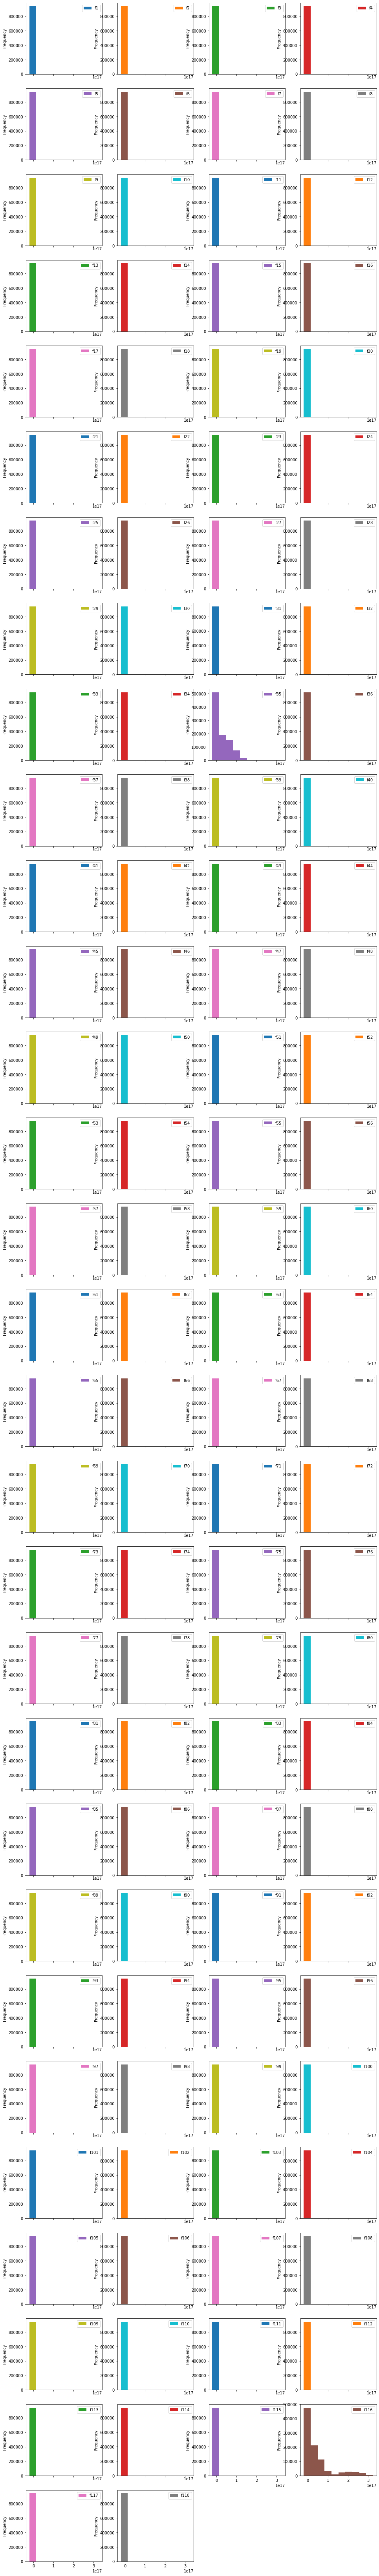

In [28]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

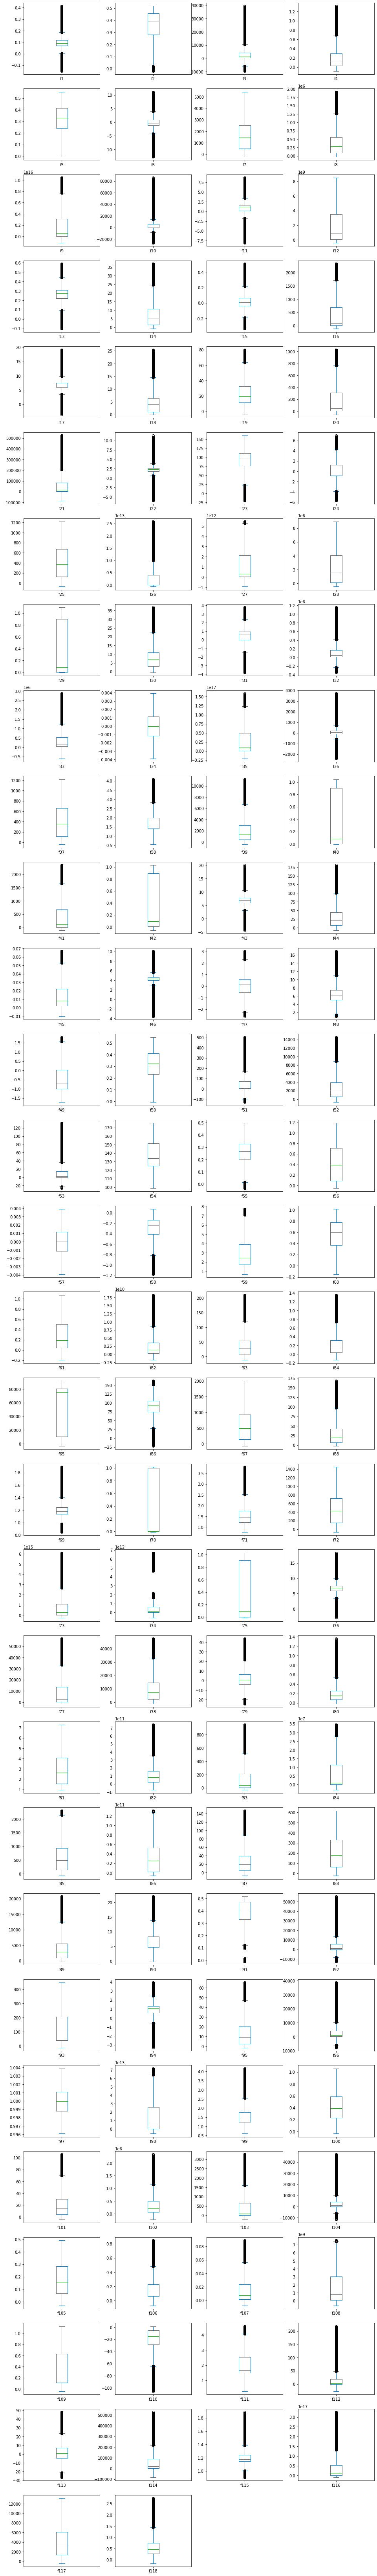

In [29]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

In [30]:
# # Correlation matrix
# fig = plt.figure(figsize=(20, 20))
# correlations = df_features_train.corr(method='pearson')
# sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
# plt.show()

In [31]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [32]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling

In [33]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="constant", fill_value=0)),
    ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 118
Number of categorical columns: 0
Total number of columns in the feature dataframe: 118


In [34]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (957919, 118) to array_features_train.shape: (957919, 118)


### 3.b) Training Data Balancing

In [35]:
# Not applicable for this iteration of the project

In [36]:
# Examine the target classes for imbalanced distribution
# Xy_original.groupby('targetVar').size()

In [37]:
# # Perform SMOTE transformation on the training data (Block #1 of 2)
# X_train_imbal = X_train_df.values
# y_train_imbal = y_train_df.values.ravel()
# print("X_train_imbal.shape: {} y_train_imbal.shape: {}".format(X_train_imbal.shape, y_train_imbal.shape))

In [38]:
# # Perform SMOTE transformation on the training data (Block #2 of 2)
# print ('Original class distribution - 1: {} | 0: {}'.format((y_train_imbal==1).sum(), (y_train_imbal==0).sum()))
# over_sample = SMOTE(sampling_strategy=0.05, random_state=RNG_SEED)
# under_sample = RandomUnderSampler(sampling_strategy=1.0, random_state=RNG_SEED)
# steps = [('o', over_sample), ('u', under_sample)]
# sample_pipeline = Pipeline(steps=steps)
# X_train, y_train = sample_pipeline.fit_resample(X_train_imbal, y_train_imbal)
# print ('Resampled class distribution - 1: {} | 0: {}'.format((y_train==1).sum(), (y_train==0).sum()))

### 3.c) Display the Final Datasets for Model-Building

In [39]:
# Finalize the training dataset for the modeling activities
# array_features_train = df_features_train.to_numpy()
array_target_train = df_target_train.ravel()
# label_encoder = preprocessing.LabelEncoder()
# array_target_train = label_encoder.fit_transform(df_target_train)
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (957919, 118) array_target_train.shape: (957919,)


In [40]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [41]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [42]:
start_time_module = datetime.now()
reset_random()
auto_model = ak.StructuredDataClassifier(loss=DEFAULT_LOSS,
                                      metrics=DEFAULT_METRICS,
                                      max_trials=MAX_TRIALS,
                                      objective=keras_tuner.Objective("val_auc", direction="max"),
                                      seed=RNG_SEED)
auto_model.fit(x=array_features_train,
               y=array_target_train,
               epochs=MAX_EPOCHS,
               validation_split=VAL_SET_RATIO,
               batch_size=BATCH_SIZE,
               verbose=1)
print('Total time for model fitting:', (datetime.now() - start_time_module))

Trial 10 Complete [00h 33m 30s]
val_auc: 0.5907442569732666

Best val_auc So Far: 0.5907442569732666
Total elapsed time: 05h 11m 41s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
29935/29935 [==============================] - 192s 6ms/step - loss: 0.6883 - auc: 0.5642
Epoch 2/10
29935/29935 [==============================] - 191s 6ms/step - loss: 0.6840 - auc: 0.5767
Epoch 3/10
29935/29935 [==============================] - 191s 6ms/step - loss: 0.6827 - auc: 0.5815
Epoch 4/10
29935/29935 [==============================] - 191s 6ms/step - loss: 0.6816 - auc: 0.5856
Epoch 5/10
29935/29935 [==============================] - 192s 6ms/step - loss: 0.6807 - auc: 0.5890
Epoch 6/10
29935/29935 [==============================] - 191s 6ms/step - loss: 0.6796 - auc: 0.5928
Epoch 7/10
29935/29935 [==============================] - 190s 6ms/step - loss: 0.6789 - auc: 0.5952
Epoch 8/10
29935/29935 [==============================] - 191s 6ms/step - loss: 0.6782 - auc: 0.5973
Epoch 9/10
29935/2993

2022-01-13 23:14:41.708675: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./structured_data_classifier/best_model/assets
Total time for model fitting: 5:50:51.295936


In [43]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [44]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [45]:
final_model = auto_model.export_model()
final_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 118)]             0         
_________________________________________________________________
multi_category_encoding (Mul (None, 118)               0         
_________________________________________________________________
normalization (Normalization (None, 118)               237       
_________________________________________________________________
dense (Dense)                (None, 128)               15232     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
re_lu (ReLU)                 (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0     

### 5.b) Load Test Dataset and Make Predictions

In [46]:
if not os.path.exists(TEST_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021sep/test.csv

In [47]:
df_features_test = pd.read_csv(TEST_DATASET, index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

       id        f1        f2        f3       f4       f5       f6       f7  \
0  957919  0.165850  0.487050   1295.00  0.02310  0.31900  0.90188   573.29   
1  957920  0.129650  0.373480   1763.00  0.72884  0.33247 -1.26310   875.55   
2  957921  0.120190  0.445210    736.26  0.04615  0.29605  0.31665  2659.50   
3  957922  0.054008  0.395960    996.14  0.85934  0.36678 -0.17060   386.56   
4  957923  0.079947 -0.006919  10574.00  0.34845  0.45008 -1.84200  3027.00   

         f8            f9  ...     f109     f110    f111      f112     f113  \
0    3743.7  2.705700e+12  ...  0.16253 -22.1890  2.0655  0.430880 -10.7410   
1  554370.0  5.955700e+14  ...  0.81528  -1.6342  1.5736 -1.071200  11.8320   
2  317140.0  3.977800e+14  ...  0.81831 -32.7800  2.1364 -1.931200  -3.2804   
3  325680.0 -3.432200e+13  ...  0.86559  -2.4162  1.5199 -0.011633   1.3840   
4  428150.0  9.291500e+11  ...  0.25190 -18.6300  3.7387  0.757080  -4.9405   

      f114    f115          f116    f117     f118 

In [48]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['id'] = df_features_test['id']
print(df_kaggle_submission.head())

       id
0  957919
1  957920
2  957921
3  957922
4  957923


In [49]:
# Dropping features
df_features_test.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

         f1        f2        f3       f4       f5       f6       f7        f8  \
0  0.165850  0.487050   1295.00  0.02310  0.31900  0.90188   573.29    3743.7   
1  0.129650  0.373480   1763.00  0.72884  0.33247 -1.26310   875.55  554370.0   
2  0.120190  0.445210    736.26  0.04615  0.29605  0.31665  2659.50  317140.0   
3  0.054008  0.395960    996.14  0.85934  0.36678 -0.17060   386.56  325680.0   
4  0.079947 -0.006919  10574.00  0.34845  0.45008 -1.84200  3027.00  428150.0   

             f9       f10  ...     f109     f110    f111      f112     f113  \
0  2.705700e+12  6221.000  ...  0.16253 -22.1890  2.0655  0.430880 -10.7410   
1  5.955700e+14   934.430  ...  0.81528  -1.6342  1.5736 -1.071200  11.8320   
2  3.977800e+14   131.810  ...  0.81831 -32.7800  2.1364 -1.931200  -3.2804   
3 -3.432200e+13   -26.473  ...  0.86559  -2.4162  1.5199 -0.011633   1.3840   
4  9.291500e+11  5999.400  ...  0.25190 -18.6300  3.7387  0.757080  -4.9405   

      f114    f115          f116    f1

In [50]:
# Finalize the test dataset for the modeling testing
array_features_test = preprocessor.transform(df_features_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (493474, 118) to array_features_test.shape: (493474, 118)


In [51]:
# Make batched predictions
test_predictions = final_model.predict(array_features_test)
print(test_predictions)

[[0.4974837 ]
 [0.36474416]
 [0.3660898 ]
 ...
 [0.7292763 ]
 [0.3907786 ]
 [0.5599764 ]]


In [52]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021sep/sample_solution.csv'
df_sample_submission = pd.read_csv(dataset_path, index_col=False)
df_sample_submission.drop(columns=['id'], inplace=True)
submission_header = list(df_sample_submission.columns)
print(submission_header)

['claim']


In [53]:
df_kaggle_submission[submission_header] = test_predictions
print(df_kaggle_submission.head())

       id     claim
0  957919  0.497484
1  957920  0.364744
2  957921  0.366090
3  957922  0.437269
4  957923  0.594318


In [54]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20220113-2316.csv


In [55]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [56]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 5:53:50.995236
